In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  error: subprocess-exited-with-error
  
  × Running setup.py install for tensorflow-gpu did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for tensorflow-gpu ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> tensorflow-gpu

note: This is an issue with the packag

In [116]:
!nvidia-smi

Wed Jan 25 10:16:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    27W /  70W |   9014MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [117]:
# import the libraries as shown below
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

In [118]:
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [119]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/MyDrive/Lab/data/Cotton_dataset/train',
    shuffle=True,
    image_size = (IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/MyDrive/Lab/data/Cotton_dataset/test',
    shuffle=True,
    image_size = (IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/MyDrive/Lab/data/Cotton_dataset/val',
    shuffle=True,
    image_size = (IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1961 files belonging to 4 classes.
Found 19 files belonging to 4 classes.
Found 324 files belonging to 4 classes.


In [120]:
# Import the Inception V3 library as shown below and add preprocessing layer to the front of 
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [121]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [122]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Lab/data/Cotton_dataset/train/*')
folders

['/content/drive/MyDrive/Lab/data/Cotton_dataset/train/fresh cotton plant',
 '/content/drive/MyDrive/Lab/data/Cotton_dataset/train/fresh cotton leaf',
 '/content/drive/MyDrive/Lab/data/Cotton_dataset/train/diseased cotton plant',
 '/content/drive/MyDrive/Lab/data/Cotton_dataset/train/diseased cotton leaf']

In [123]:
class_names = training_dataset.class_names
class_names

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

In [124]:
len(training_dataset)

62

Plot Sample of images

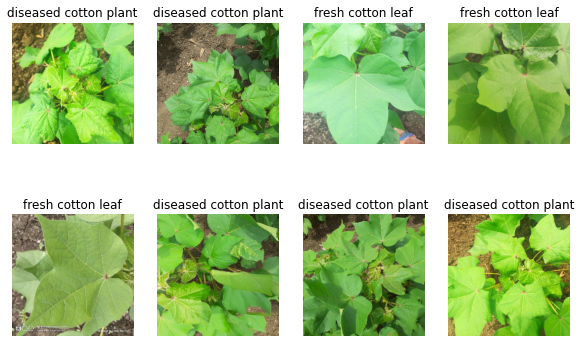

In [125]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in training_dataset.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [126]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [127]:
prediction = Dense(len(folders), activation ='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [128]:
# view the structure of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_470 (Conv2D)            (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_470 (Batch  (None, 111, 111, 32  96         ['conv2d_470[0][0]']             
 Normalization)                 )                                                           

In [129]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer ='adam',
  metrics= ['accuracy']
)

In [130]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [131]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory( '/content/drive/MyDrive/Lab/data/Cotton_dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1961 images belonging to 4 classes.


In [132]:
training_set.image_shape

(224, 224, 3)

In [133]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Lab/data/Cotton_dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 19 images belonging to 4 classes.


In [134]:
test_set.image_shape

(224, 224, 3)

In [135]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=EPOCHS,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-135-d42720e1831f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/50
62/62 [==============================] - 53s 801ms/step - loss: 2.2388 - accuracy: 0.7425 - val_loss: 0.6990 - val_accuracy: 0.8947
Epoch 2/50
62/62 [==============================] - 38s 611ms/step - loss: 0.6251 - accuracy: 0.8955 - val_loss: 2.4077 - val_accuracy: 0.6842
Epoch 3/50
62/62 [==============================] - 40s 644ms/step - loss: 0.7401 - accuracy: 0.8980 - val_loss: 0.3468 - val_accuracy: 0.9474
Epoch 4/50
62/62 [==============================] - 42s 684ms/step - loss: 0.9132 - accuracy: 0.8909 - val_loss: 0.7090 - val_accuracy: 0.8421
Epoch 5/50
62/62 [==============================] - 39s 614ms/step - loss: 0.8294 - accuracy: 0.8965 - val_loss: 0.3147 - val_accuracy: 0.8947
Epoch 6/50
62/62 [==============================] - 39s 631ms/step - loss: 0.4734 - accuracy: 0.9281 - val_loss: 0.7651 - val_accuracy: 0.8947
Epoch 7/50
62/62 [==============================] - 38s 613ms/step - loss: 0.4821 - accuracy: 0.9342 - val_loss: 0.1230 - val_accuracy: 0.9474

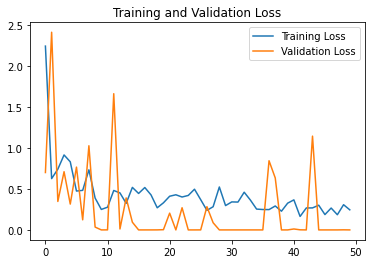

<Figure size 432x288 with 0 Axes>

In [142]:
import matplotlib.pyplot as plt
# plot the loss
plt.title('Training and Validation Loss')
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
#xlable = 'validation lossin %'
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


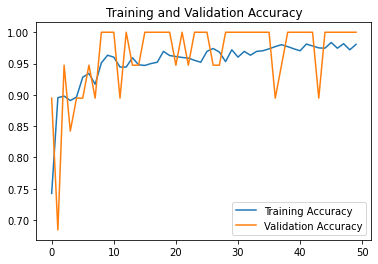

<Figure size 432x288 with 0 Axes>

In [143]:
# plot the accuracy
plt.title('Training and Validation Accuracy')
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.show()
plt.savefig('AccVal_acc')

In [144]:
scores = model.evaluate(test_set)

1/1 [==============================] - 6s 6s/step - loss: 9.1030e-06 - accuracy: 1.0000


In [145]:
scores

[9.103042430069763e-06, 1.0]

In [146]:
r

In [148]:
r.params

{'verbose': 1, 'epochs': 50, 'steps': 62}

In [149]:
r.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [150]:
r.history['accuracy']

[0.7424783110618591,
 0.8954614996910095,
 0.8980112075805664,
 0.8908720016479492,
 0.8964813947677612,
 0.9280979037284851,
 0.9342172145843506,
 0.9168791174888611,
 0.9510453939437866,
 0.9632840156555176,
 0.9602243900299072,
 0.9444161057472229,
 0.9444161057472229,
 0.9592044949531555,
 0.9479857087135315,
 0.9469658136367798,
 0.9500254988670349,
 0.9520652890205383,
 0.9694033861160278,
 0.9627740979194641,
 0.9612442851066589,
 0.959714412689209,
 0.9586945176124573,
 0.9551249146461487,
 0.9520652890205383,
 0.9694033861160278,
 0.9739928841590881,
 0.9683834910392761,
 0.95308518409729,
 0.9719530940055847,
 0.9602243900299072,
 0.9694033861160278,
 0.9632840156555176,
 0.9694033861160278,
 0.9704232811927795,
 0.9734829068183899,
 0.9770525097846985,
 0.9801121950149536,
 0.9770525097846985,
 0.9734829068183899,
 0.9704232811927795,
 0.9811320900917053,
 0.9780724048614502,
 0.9750127196311951,
 0.9745028018951416,
 0.9836817979812622,
 0.9745028018951416,
 0.9816420078277

True Image Title :  diseased cotton leaf
1/1 [==============================] - 0s 34ms/step
Model Predicted label :  diseased cotton leaf


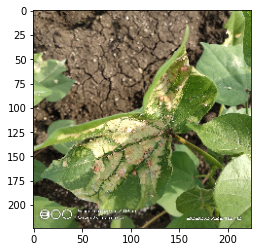

In [152]:
for image_batch,label_batch in testing_dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    print("True Image Title : ",class_names[label_batch[0].numpy()])
    prediction = model.predict(image_batch)
    print("Model Predicted label : ",class_names[np.argmax(prediction[0])])

In [153]:
r.history['accuracy']

[0.7424783110618591,
 0.8954614996910095,
 0.8980112075805664,
 0.8908720016479492,
 0.8964813947677612,
 0.9280979037284851,
 0.9342172145843506,
 0.9168791174888611,
 0.9510453939437866,
 0.9632840156555176,
 0.9602243900299072,
 0.9444161057472229,
 0.9444161057472229,
 0.9592044949531555,
 0.9479857087135315,
 0.9469658136367798,
 0.9500254988670349,
 0.9520652890205383,
 0.9694033861160278,
 0.9627740979194641,
 0.9612442851066589,
 0.959714412689209,
 0.9586945176124573,
 0.9551249146461487,
 0.9520652890205383,
 0.9694033861160278,
 0.9739928841590881,
 0.9683834910392761,
 0.95308518409729,
 0.9719530940055847,
 0.9602243900299072,
 0.9694033861160278,
 0.9632840156555176,
 0.9694033861160278,
 0.9704232811927795,
 0.9734829068183899,
 0.9770525097846985,
 0.9801121950149536,
 0.9770525097846985,
 0.9734829068183899,
 0.9704232811927795,
 0.9811320900917053,
 0.9780724048614502,
 0.9750127196311951,
 0.9745028018951416,
 0.9836817979812622,
 0.9745028018951416,
 0.9816420078277

In [157]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
                                                                  
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


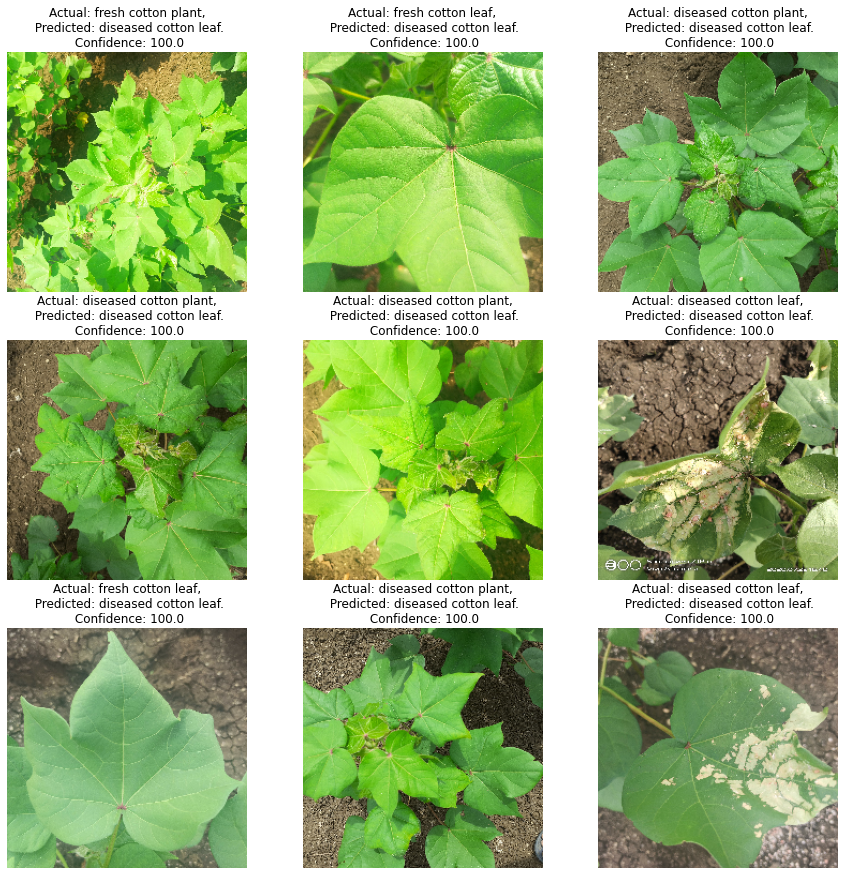

In [164]:
plt.figure(figsize=(15,15))
for images, labels in testing_dataset.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype('uint32'))

      predicted_class, confidence = predict(model, images[i].numpy())
      actual_class = class_names[labels[i]]

      plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")


      plt.axis("off")

In [166]:
# save it as a ipynb file


from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/Colab Notebooks/Cotton_plant_classification_model_inceptionv3.ipynb')
